### Data Preparation

In [365]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from pandas import read_csv
#Lets load the dataset and sample some
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
data = read_csv('housing.csv', header=None, delimiter=r"\s+", names=column_names)
print(data.head(5))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [366]:
legend = list(data.columns)[:-1]
legend_b = legend + ['BIAS']
legend_b

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'BIAS']

In [367]:
print(data.shape, data.isna().values.any(), data.duplicated().values.any())

(506, 14) False False


In [368]:
# Split data
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

In [369]:
X_train.shape, X_test.shape

((337, 13), (169, 13))

In [370]:
X_train = np.array(X_train.values.tolist())
X_test = np.array(X_test.values.tolist())
y_train = np.array(y_train.values.tolist())
y_test = np.array(y_test.values.tolist())

In [371]:
def Z_score(data):
  mean = np.mean(data, axis=0)
  std_dev = np.std(data, axis=0)
  data_normalized = (data - mean) / std_dev
  return data_normalized

def min_max(data):
  min_values = np.min(data, axis=0)
  max_values = np.max(data, axis=0)
  data_normalized = (data - min_values) / (max_values - min_values)
  return data_normalized

X_train = Z_score(X_train)
y_train = Z_score(y_train)
X_test = Z_score(X_test)
y_test = Z_score(y_test)

In [372]:
max(y_train), min(y_train)

(2.8711639519588936, -1.852849637112101)

### Least Mean Squares

#### LMS with gradient clip

In [373]:
# Full Learning with Anomaly Drop
def lms(data_set, w, lr, train=True):
  J = 0
  j = 0
  c = 0
  N = len(data_set)
  window_left = N-50 if N-50>=0 else 0
  gradient = 0
  
  for data_, label_ in data_set:
    # print("Data is: ", data)
    if c >= window_left:
      pred = w.T @ data_
      j = np.power((label_ - pred), 2) / (2*N)
      if j > 0.5:
        continue
      gradient += (label_ - pred) * data_ / N
      J += j

    c += 1
  w = w + lr * gradient
  print('Error: ', J)
  # print('error: {}, weight:{}'.format(E, w))
  return w, J

#### LMS with slide window

In [374]:
# Slide Window
def lms(data_set, w, lr, train=True):
  J = 0
  c = 0
  N = len(data_set) if len(data_set)-50>=0 or train == False else 50

  window_left = N-50 if N-50>=0 else 0
  gradient = 0

  for data_, label_ in data_set:
    if train:
      if c >= window_left:
        pred = w.T @ data_
        gradient += (label_ - pred) * data_ / N
        J += np.power((label_ - pred), 2) / (2*N)
    else:
      pred = w.T @ data_
      J += np.power((label_ - pred), 2) / (2*N)
      # print(J)
    c += 1
  print('Error: ', J)
  if train:
    w = w + lr * gradient
    return w, J
  else:
    return J
  
  # print('error: {}, weight:{}'.format(E, w))
  

#### LMS with multiple run

In [651]:
def lms(X_train, y_train, w, lr, train=True):
  J = 0
  N = X_train.shape[0] if train==True else 1
  gradient = 0

  for data_, label_ in zip(X_train, y_train):
    pred = w.T @ data_
    J += np.power((label_ - pred), 2) / (2*N)
    if train:
        gradient = (label_ - pred) * data_
        w = w + lr * gradient

  # print('Error: ', J)
  if train:
    return w, J
  else:
    return J

In [376]:
np.max(y_train), np.min(y_train)

(2.8711639519588936, -1.852849637112101)

#### LMS with stochastic regressor

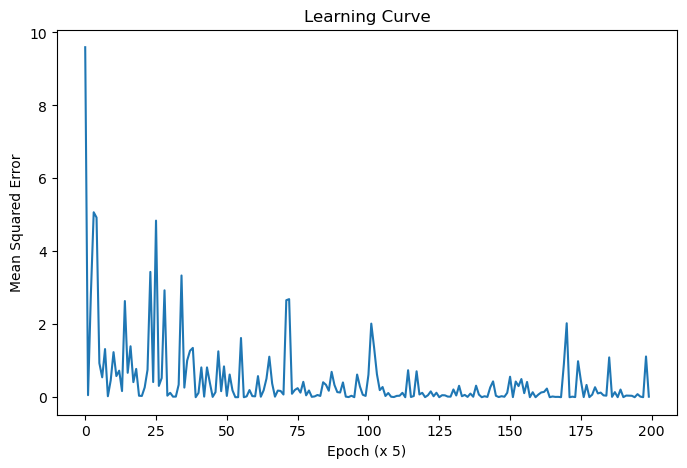

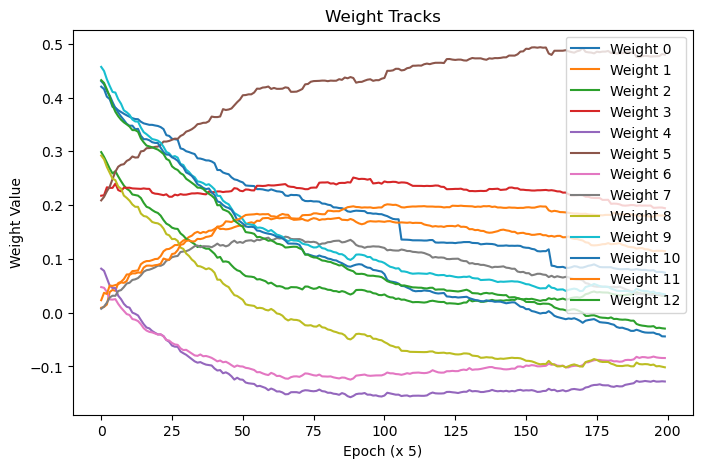

In [426]:
import random

def lms_n(train_data, train_label, w, lr, train=True):
  pred = w.T @ train_data
  J = np.power((train_label - pred), 2) / 2
  if train:
    gradient = (train_label - pred) * train_data
    w = w + lr * gradient
    return w, J
  return J

weights = np.random.rand(X_train.shape[1]) * 0.5
learning_rate = 0.001
epoch = 1000
weight_history_n = []
error_history_n = []

for e in range(epoch):
    rand = random.randint(0, X_train.shape[0] - 1)
    # print("==== Epoch : {}-{} ====".format(e, rand))
    
    weights, loss = lms_n(X_train[rand],y_train[rand], weights, learning_rate)
    weight_history_n.append(weights.copy())
    error_history_n.append(loss.copy())

weight_history_n = np.array(weight_history_n) 
error_history_n = np.array(error_history_n)

plt.figure(figsize=(8,5))
sampling = np.arange(0, 1000,5)
plt.plot(np.arange(len(sampling)), error_history_n[sampling])
plt.xlabel('Epoch (x 5)')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve')
plt.show()

# Plotting the weight tracks
plt.figure(figsize=(8,5))
for i in range(X_train.shape[1]):
    plt.plot([w[i] for w in weight_history_n[sampling]], label=f'Weight {i}')
plt.xlabel('Epoch (x 5)')
plt.ylabel('Weight Value')
plt.title('Weight Tracks')
plt.legend()
plt.show()

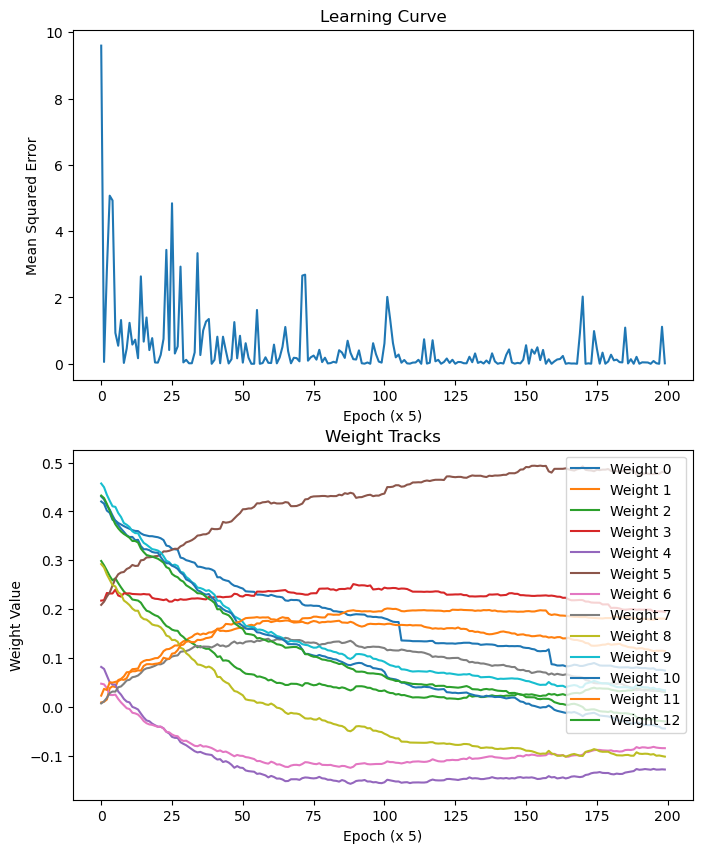

In [594]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
sampling = np.arange(0, 1000,5)
ax1.plot(np.arange(len(sampling)), error_history_n[sampling])
ax1.set_xlabel('Epoch (x 5)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Learning Curve')

# Plotting the weight tracks
for i in range(X_train.shape[1]):
    ax2.plot([w[i] for w in weight_history_n[sampling]], label=f'Weight {i}')
ax2.set_xlabel('Epoch (x 5)')
ax2.set_ylabel('Weight Value')
ax2.set_title('Weight Tracks')
ax2.legend()
fig.savefig("LMS with stochastic decent.png")

In [538]:
weights = np.random.rand(X_train.shape[1])
# weights = np.full(X_train.shape[1], 0.1)
bias = np.random.rand(1)
learning_rate = 0.001

In [539]:
weights

array([0.33044801, 0.03627058, 0.74450827, 0.7786599 , 0.78738627,
       0.61742756, 0.64809385, 0.547349  , 0.36365558, 0.45224219,
       0.28919263, 0.30948008, 0.19956513])

In [653]:
X_t = data.iloc[:, :]
X_t = np.array(X_t.values.tolist())
X_t = Z_score(X_t)

y_t = data.iloc[:, -1]
y_t = np.array(y_t.values.tolist())
y_t = Z_score(y_t)

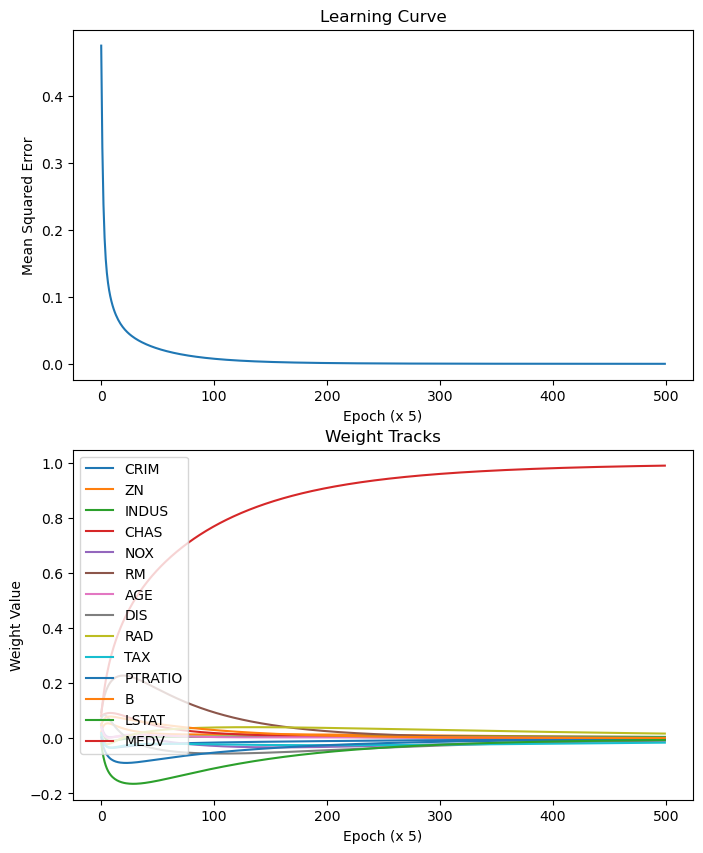

In [659]:
# No bias
weights = np.array([0.33044801, 0.03627058, 0.74450827, 0.7786599 , 0.78738627,
       0.61742756, 0.64809385, 0.547349  , 0.36365558, 0.45224219,
       0.28919263, 0.30948008, 0.19956513, 0.33044801]) * 0.1
epoch = 500
learning_rate = 0.0001
weight_history = []
bias_history = []
error_history = []

for e in range(epoch):
    # print("==== Epoch : {} ====".format(e))
    weights, loss = lms(X_t,y_t, weights, learning_rate)
    weight_history.append(weights)
    error_history.append(loss)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

ax1.plot(np.arange(len(error_history)), error_history)
ax1.set_xlabel('Epoch (x 5)')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Learning Curve')

# Plotting the weight tracks
for i in range(X_t.shape[1]):
    ax2.plot([w[i] for w in weight_history], label=list(data.columns)[i])
ax2.set_xlabel('Epoch (x 5)')
ax2.set_ylabel('Weight Value')
ax2.set_title('Weight Tracks')
ax2.legend()
fig.savefig("Target value.png")

In [644]:
# No bias
weights = np.array([0.33044801, 0.03627058, 0.74450827, 0.7786599 , 0.78738627,
       0.61742756, 0.64809385, 0.547349  , 0.36365558, 0.45224219,
       0.28919263, 0.30948008, 0.19956513])
epoch = 200
learning_rate = 0.0001
weight_history = []
bias_history = []
error_history = []

for e in range(epoch):
    # print("==== Epoch : {} ====".format(e))
    weights, loss = lms(X_train,y_train, weights, learning_rate)
    weight_history.append(weights)
    error_history.append(loss)

In [645]:
# # No bias
# i = 1
# dataset = []
# weight_history = []
# bias_history = []
# error_history = []

# for data, label in zip(X_train, y_train):
#     print("==== input sample: {} ====".format(i))
#     dataset.append([data, label])
#     weights, loss = lms(dataset, weights, learning_rate)
#     weight_history.append(weights)
#     error_history.append(loss)

#     i += 1

In [646]:
test_loss = []
opt_w = weight_history[-1]
for _data, _label in zip(X_test, y_test):
  test_loss.append(lms([_data], [_label], opt_w, learning_rate, train=False))

mean_test_loss = np.mean(test_loss)

In [647]:
print("Final train loss is: ", error_history[-1])
print("Final test loss is: ", mean_test_loss)

Final train loss is:  0.14795132758856594
Final test loss is:  0.16324942899629777


### Least Mean Squares with bias

In [544]:
X_train_b = np.c_[X_train, np.ones((X_train.shape[0], 1))]
X_test_b = np.c_[X_test, np.ones((X_test.shape[0], 1))]

In [545]:
X_train_b.shape

(337, 14)

In [546]:
weights = np.random.rand(X_train.shape[1]+1)
# weights = np.full(X_train.shape[1], 0.1)
# bias = np.random.rand(1)
learning_rate = 0.00001

In [547]:
weights, weights.shape

(array([0.38245212, 0.23302834, 0.3218162 , 0.37540752, 0.65347431,
        0.79155477, 0.78612491, 0.07170792, 0.11556659, 0.67343813,
        0.53730342, 0.11857915, 0.25681546, 0.98457048]),
 (14,))

In [548]:
# Adding bias
epoch = 150
learning_rate = 0.0001
weight_history_b = []
error_history_b = []

for e in range(epoch):
    # print("==== Epoch : {} ====".format(e))
    weights, loss = lms(X_train_b,y_train, weights, learning_rate)
    weight_history_b.append(weights.copy())
    error_history_b.append(loss.copy())

In [549]:
# # Adding bias
# i = 1
# dataset_ = []
# weight_history_ = []
# bias_history_ = []
# error_history_ = []

# for data_b, label in zip(X_train_b, y_train):
#     print("==== input sample: {} ====".format(i))
#     dataset_.append([data_b, label])
#     weights, loss = lms(dataset_, weights, learning_rate)
#     weight_history_.append(weights)
#     error_history_.append(loss)

#     i += 1

In [550]:
test_loss_b = []
opt_w = weight_history_b[-1]
for _data, _label in zip(X_test_b, y_test):
  test_loss_b.append(lms([_data], [_label], opt_w, learning_rate, train=False))

mean_test_loss_b = np.mean(test_loss_b)

In [551]:
print("Final train loss is: ", error_history_b[-1])
print("Final test loss is: ", mean_test_loss_b)

Final train loss is:  0.15486083409889148
Final test loss is:  0.17218927660916405


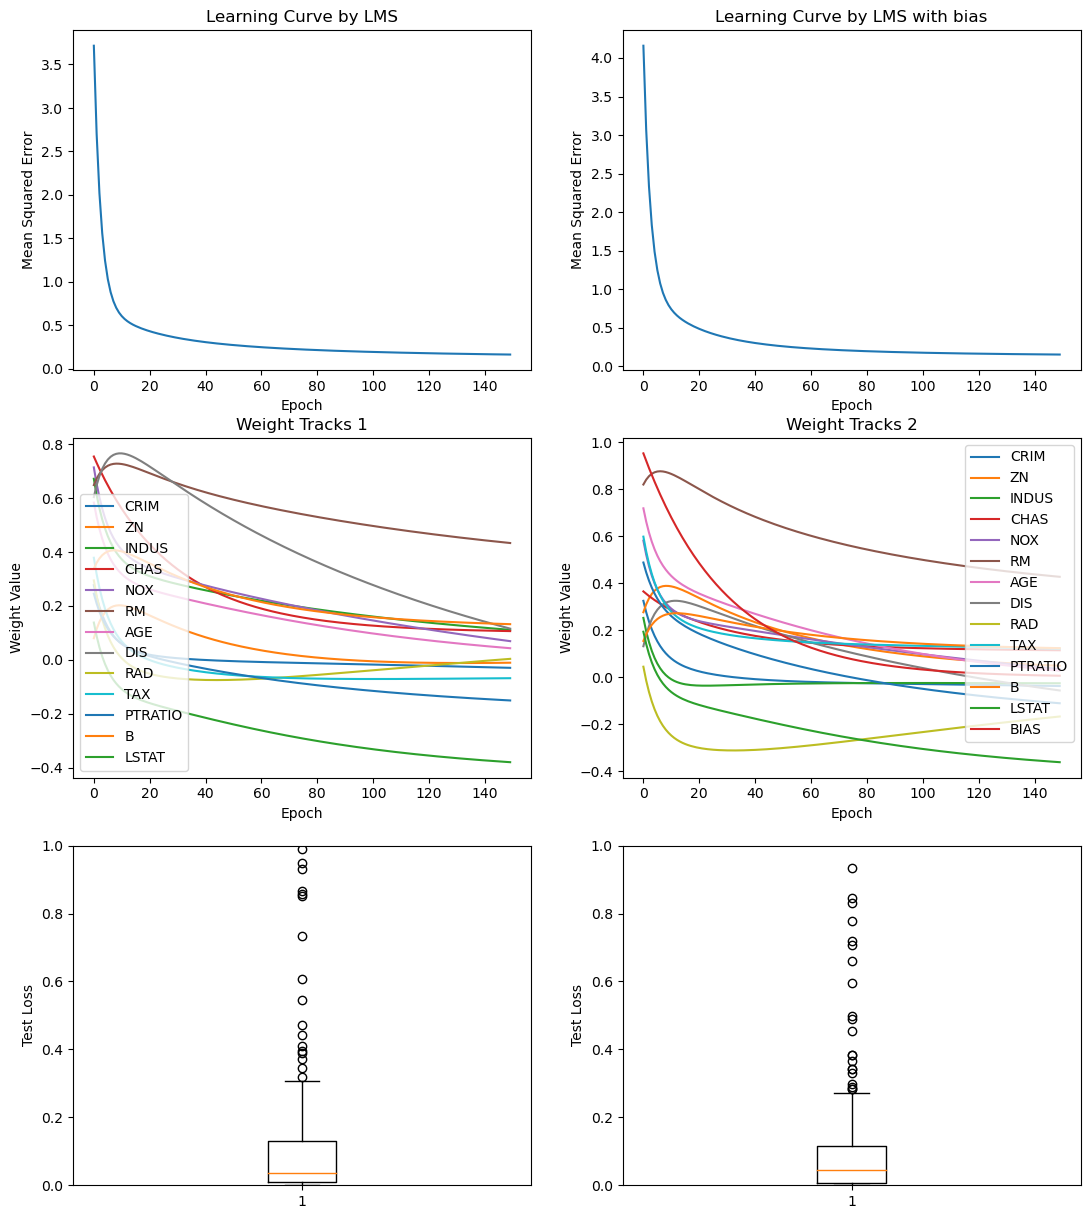

In [586]:
import matplotlib.pyplot as plt

# Plotting the learning curve
fig, axs = plt.subplots(3, 2, figsize=(13, 15))
axs[0, 0].plot(np.arange(len(error_history)), error_history)
axs[0, 0].set_title('Learning Curve by LMS')
axs[0, 0].set(xlabel='Epoch', ylabel='Mean Squared Error')

axs[0, 1].plot(np.arange(len(error_history_b)), error_history_b)
axs[0, 1].set_title('Learning Curve by LMS with bias')
axs[0, 1].set(xlabel='Epoch', ylabel='Mean Squared Error')

for i in range(X_train.shape[1]+1):
    if i < X_train.shape[1]:
      axs[1, 0].plot([w[i] for w in weight_history], label=f'Weight {i}')
    axs[1, 1].plot([w[i] for w in weight_history_b], label=f'Weight {i}')
axs[1, 0].set_title('Weight Tracks 1')
axs[1, 0].set(xlabel='Epoch', ylabel='Weight Value')
axs[1, 0].legend(legend)
axs[1, 1].set_title('Weight Tracks 2')
axs[1, 1].set(xlabel='Epoch', ylabel='Weight Value')
axs[1, 1].legend(legend_b)

axs[2, 0].boxplot(test_loss)
axs[2, 0].set_ylim(0, 1)
axs[2, 1].boxplot(test_loss_b)
axs[2, 1].set_ylabel("Test Loss")
axs[2, 1].set_ylim(0, 1)
axs[2, 0].set_ylabel("Test Loss")

plt.savefig("Bias vs no bias.png")
# plt.figure()
# plt.plot(np.arange(len(error_history)), error_history)
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.title('Learning Curve')
# plt.show()

# # Plotting the weight tracks
# plt.figure()
# for i in range(X_train.shape[1]):
#     plt.plot([w[i] for w in weight_history], label=f'Weight {i}')
# plt.xlabel('Epoch')
# plt.ylabel('Weight Value')
# plt.title('Weight Tracks')
# plt.legend()
# plt.show()

### Learning Rate Comperison

In [554]:
# No bias
def running_epochs(epoch, X_train, y_train, lr_, weights):
    weight_history = []
    error_history = []
    
    for e in range(epoch):
        # print("==== Epoch : {} Learning Rate : {} ====".format(e, lr_))
        weights, loss = lms(X_train,y_train, weights, lr_)
        weight_history.append(weights)
        error_history.append(loss)

    return weight_history, error_history

weights = np.random.rand(X_train.shape[1])
lr_set = [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]
lr_err = []
epochs = 50
for lr_ in lr_set:
   _, errors = running_epochs(epochs, X_train, y_train, lr_, weights)
   lr_err.append(errors)

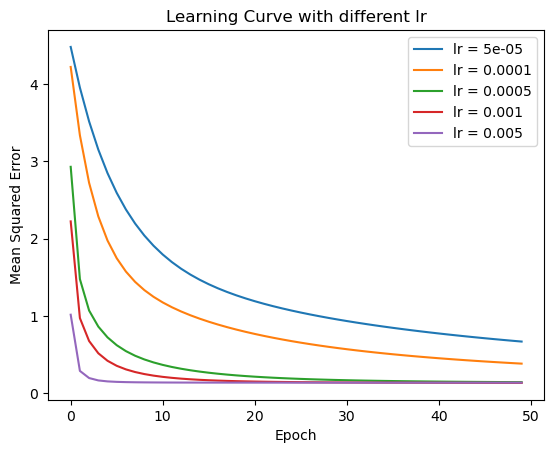

In [570]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(5):
    plt.plot(np.arange(epochs), lr_err[i], label='lr = {}'.format(lr_set[i]))
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
# plt.ylim(0, 5)
plt.title('Learning Curve with different lr')
plt.legend()
plt.savefig("Learning Curve with different learning rate.png")


# plt.figure()
# plt.xlabel('Epoch')
# plt.ylabel('Mean Squared Error')
# plt.plot(np.arange(epochs), lr_err[-1], label='lr = {}'.format(lr_set[i]))
# plt.legend()
plt.savefig("Learning Curve with different learning rate.png")